In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy
from tqdm import tqdm

import lib

In [2]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), 
        	(I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)



In [15]:
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
q = 0.05
Q = np.array([[q, q, 0.0], [q, q, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)
measurements = - (x**2 + 2*x - 2)  + np.random.normal(0, 2, 100)


In [34]:
np.dot(H,  kf.predict())

array([[74.80642499]])

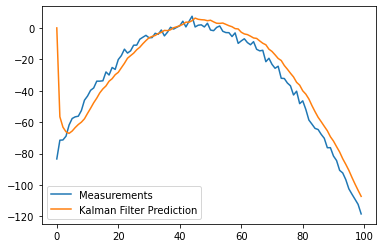

In [16]:

kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in measurements:
  predictions.append(np.dot(H,  kf.predict())[0])
  kf.update(z)

plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

In [5]:
video_path = 'inputs/PXL_20241228_181110762.mp4'
desired_fps = 7

imgs = lib.sample_video(video_path, desired_fps)
imgs = imgs[180:]

im_background = lib.calculate_background(imgs)
im_background = lib.preprocess(im_background)

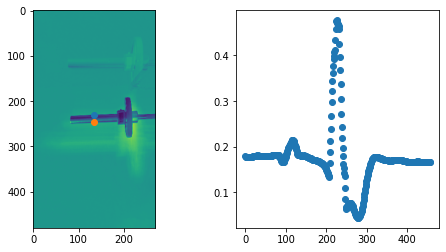

In [ ]:
bar_height_guess = 24
im = imgs[2]

im = lib.preprocess(im)
im = lib.remove_background(im, im_background)

correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x, bar_height = lib.get_features_minimal(im, bar_height_guess)

lib.plot_frame_minimal(im, correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x)


In [46]:
dt = 1.0/desired_fps
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]]) # State transition model
H = np.array([1, 0, 0]).reshape(1, 3) # Observation model. Measureable outputs
q = 0.05
Q = np.array([[q, q, 0.0], [q, q, 0.0], [0.0, 0.0, 0.0]]) # Covariance of the process noise
R = np.array([0.5]).reshape(1, 1) # Covariance of the observation noise

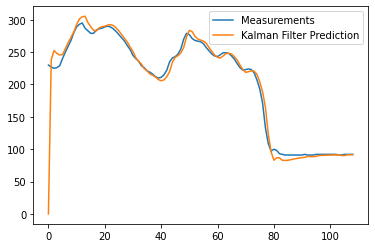

In [47]:

kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []
bar_height_guess = 24
measurements = []
for im in imgs:
  predictions.append(np.dot(H,  kf.predict())[0])

  im = lib.preprocess(im)
  im = lib.remove_background(im, im_background)

  correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x, bar_height = lib.get_features_minimal(im, bar_height_guess)
  z = np.argmax(correlation)
  measurements.append(z)

  kf.update(z)

plt.plot(range(len(measurements)), measurements, label = 'Measurements')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()

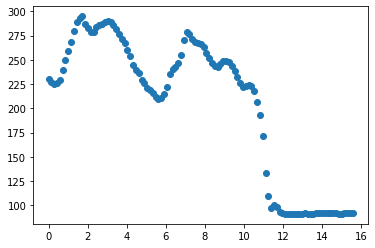

In [ ]:
duration = len(imgs)/desired_fps
t = np.linspace(0, duration, len(measurements))
